## **Detecting Pneumonia Using X-Ray Images with CNNs and Transfer Learning**

### **Project Purpose**

The primary objective of this project is to leverage advanced deep learning techniques, specifically Convolutional Neural Networks (CNNs) and transfer learning, to aid in the accurate and timely diagnosis of pneumonia in pediatric patients.

### **Introduction**

Pneumonia remains a significant global health concern, claiming the lives of over 808,000 children under the age of five in 2017 according to the World Health Organization.

We have been provided with a valuable dataset comprising 5856 chest X-ray images from children, thoughtfully curated by researchers from the University of California, San Diego. This dataset is divided into training and test sets, with each image accompanied by a label indicating the presence or absence of pneumonia. As a Deep Learning Engineer, the specific task at hand is to design and train a deep learning model using CNN architectures, optimizing its performance through the utilization of transfer learning. Transfer learning allows us to leverage pre-trained models on large datasets, enhancing the efficiency of our model training process and potentially improving its ability to generalize to new data.

By successfully implementing this pneumonia detection model, the goal is to provide healthcare professionals with a powerful tool that can assist in the accurate identification of pneumonia in pediatric patients. This project aligns with my commitment to harnessing technology for positive social impact, particularly in the realm of child health, where early and accurate diagnosis can make a substantial difference in saving lives.

### **Setting up the Environment**

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, Model, Input, applications, initializers
import matplotlib.pyplot as plt
%matplotlib inline

### **Image Data Preparation**

In [2]:
# Download tar.gz file from specified URL using wget
!wget https://dsserver-prod-resources-1.s3.amazonaws.com/cnn/xray_dataset.tar.gz

# Import tarfile module to work with tar archives
import tarfile

# Function to extract contents from a tar.gz file
def extract_tar_gz(file_path, output_path):
    # Open the tar.gz file in read-only mode with gzip compression
    with tarfile.open(file_path, 'r:gz') as tar:
        # Extract all contents of the tar.gz file to specified output path
        tar.extractall(path=output_path)

# Call the extract_tar_gz function with the downloaded file
extract_tar_gz('xray_dataset.tar.gz', '.')

--2024-01-07 21:05:05--  https://dsserver-prod-resources-1.s3.amazonaws.com/cnn/xray_dataset.tar.gz
Resolving dsserver-prod-resources-1.s3.amazonaws.com (dsserver-prod-resources-1.s3.amazonaws.com)... 52.216.43.97, 3.5.25.197, 52.216.37.97, ...
Connecting to dsserver-prod-resources-1.s3.amazonaws.com (dsserver-prod-resources-1.s3.amazonaws.com)|52.216.43.97|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1223407715 (1.1G) [application/x-gzip]
Saving to: ‘xray_dataset.tar.gz’

xray_dataset.tar.gz 100%[===================>]   1.14G  66.4MB/s    in 19s     

2024-01-07 21:05:24 (61.8 MB/s) - ‘xray_dataset.tar.gz’ saved [1223407715/1223407715]



In [3]:
# Define training, validation, and test sets using image_dataset_from_directory
train_set = tf.keras.utils.image_dataset_from_directory(
    directory = 'chest_xray/train/',
    labels = 'inferred',
    label_mode = 'categorical',
    batch_size = 128,
    image_size = (256,256),
    validation_split = 0.20,
    subset = 'training',
    seed = 417)

validation_set = tf.keras.utils.image_dataset_from_directory(
    directory = 'chest_xray/train/',
    labels = 'inferred',
    label_mode = 'categorical',
    batch_size = 128,
    image_size = (256,256),
    validation_split = 0.20,
    subset = 'validation',
    seed = 417)

test_set = tf.keras.utils.image_dataset_from_directory(
    directory = 'chest_xray/test/',
    labels = 'inferred',
    label_mode = 'categorical',
    batch_size = 128,
    image_size = (256,256))

# Rescaling layer to normalize pixel values between [0,1]
normalization_layer = layers.Rescaling(1/256)

# Apply normalization to training, validation, and test sets using the map function
train_set_normalized = train_set.map(lambda x, y: (normalization_layer(x), y))
validation_set_normalized = validation_set.map(lambda x, y: (normalization_layer(x), y))
test_set_normalized = test_set.map(lambda x, y: (normalization_layer(x), y))



Found 5232 files belonging to 2 classes.
Using 4186 files for training.
Found 5232 files belonging to 2 classes.
Using 1046 files for validation.
Found 624 files belonging to 2 classes.


### **Data Exploration and Visualization**

In [4]:
# Display training set class names
train_set.class_names

['NORMAL', 'PNEUMONIA']

In [5]:
# Take first batch from training set
train_set_elements = train_set.take(1)
# Iterate over batch to access images and labels
for images, labels in train_set_elements:
    # Convert TensorFlow tensors to NumPy arrays
    images = images.numpy()
    labels = labels.numpy()

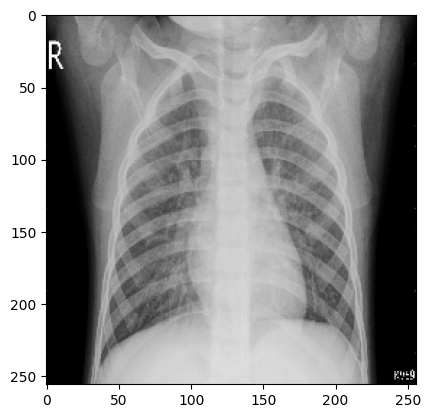

Training Set Image Label: [0. 1.]
Training Set Image Shape: (256, 256, 3)


In [6]:
# Display first image in batch, divide by 255.0 to normalize pixel values in range [0, 1]
plt.imshow(images[0]/255.0)
plt.show()
# Print label and shape information of first image
print(f'Training Set Image Label: {labels[0]}')
print(f'Training Set Image Shape: {images[0].shape}')

In [7]:
# Take first batch from test set
test_set_elements = test_set.take(1)
# Iterate over batch to access images and labels
for images, labels in test_set_elements:
  # Convert TensorFlow tensors to NumPy arrays
  images = images.numpy()

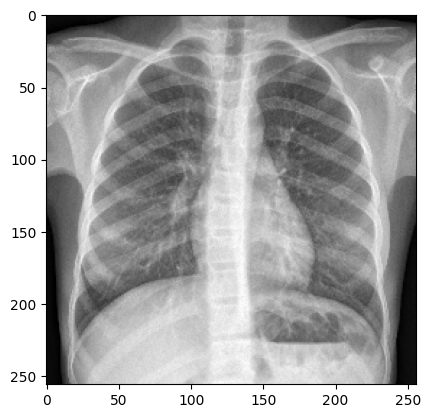

Test Set Image Label: [1. 0.]


In [8]:
# Display first image in batch, divide by 255.0 to normalize pixel values in range [0, 1]
plt.imshow(images[16]/255.0)
plt.show()
# Print label information of first image
print(f"Test Set Image Label: {labels[16]}")

**Model Complexity and Image Augmentations for Pediatric Chest X-ray Dataset**

In light of the dataset characteristics and its challenges: non-centered X-rays, varied rotation angles, and unexpected three channels, a more sophisticated model might indeed be necessary to effectively extract meaningful features, especially considering the complex structures in pediatric chest X-rays.

It is important to address the issue of rotation as part of the data augmentation process. Incorporating image rotation techniques during training can enhance the model's ability to generalize across different orientations, making it more robust and adaptable when faced with variations in how X-rays were captured.

Additionally, because of the lack of explicit information in the X-rays and the potential challenge posed by overlapping structures, other augmentations such as flipping, scaling, and translation could be beneficial. These augmentations can introduce variability in the dataset, aiding the model in learning invariant features while improving its overall performance.

The presence of three channels in seemingly grayscale images may require careful preprocessing to ensure compatibility with models designed for grayscale inputs. Conversion to a single-channel format or exploration of methods to utilize the additional channels effectively should be considered during the data preprocessing stage.

In [9]:
# Create a Sequential model
cnn_model = models.Sequential()

# Add convolutional layer
cnn_model.add(layers.Conv2D(filters = 16, kernel_size = 3, strides = 2, activation = 'relu', input_shape = (256,256,3)))
# Add max pooling layer
cnn_model.add(layers.MaxPooling2D(pool_size = 3, strides = 2))
# Flatten output before feeding into dense layers
cnn_model.add(layers.Flatten())

# Add dense layer with 16 units
cnn_model.add(layers.Dense(16, activation = 'relu'))
# Add output layer with 2 units (assuming a binary classification task)
cnn_model.add(layers.Dense(2))

# Define optimizer, loss function, and metrics for model compilation
opt = tf.keras.optimizers.Adam(learning_rate = 0.01)
loss = tf.keras.losses.CategoricalCrossentropy(from_logits = True)
cnn_model.compile(optimizer = opt, loss = loss, metrics = ['accuracy'])

# Display a summary of the model architecture
cnn_model.summary()

# Train model on normalized training set for 5 epochs using validation set
cnn_model.fit(train_set_normalized, epochs = 5, validation_data = validation_set_normalized)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 127, 127, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 16)        0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 63504)             0         
                                                                 
 dense (Dense)               (None, 16)                1016080   
                                                                 
 dense_1 (Dense)             (None, 2)                 34        
                                                                 
Total params: 1016562 (3.88 MB)
Trainable params: 1016562 (3.88 MB)
Non-trainable params: 0 (0.00 Byte)
__________________

The high accuracies in both training and validation sets after only 5 epochs suggest potential overfitting. To mitigate this, incorporating regularization, data augmentation, and additional fully-connected layers can enhance the model's generalization capacity. These measures aim to strike a balance between capturing intricate patterns in the training data and ensuring robust performance on unseen data.







In [10]:
# Create a Sequential model
cnn_model = models.Sequential()

# Add data augmentation layers: random zoom and random rotation
cnn_model.add(layers.RandomZoom(height_factor=0.1))
cnn_model.add(layers.RandomRotation(factor=0.2))

#Add convolution and max pooling layers
cnn_model.add(layers.Conv2D(filters=128, kernel_size=3, strides=2, activation='relu', input_shape=(256, 256, 3)))
cnn_model.add(layers.MaxPooling2D(pool_size=3, strides=2))

cnn_model.add(layers.Conv2D(filters=256, kernel_size=3, strides=2, activation='relu'))
cnn_model.add(layers.MaxPooling2D(pool_size=3, strides=2))

# Flatten output before feeding into dense layers
cnn_model.add(layers.Flatten())

# Fully-connected layers with dropout for regularization
cnn_model.add(layers.Dense(256, activation='relu'))
cnn_model.add(layers.Dropout(0.5))

cnn_model.add(layers.Dense(64, activation='relu'))
cnn_model.add(layers.Dropout(0.5))

cnn_model.add(layers.Dense(32, activation='relu'))
cnn_model.add(layers.Dropout(0.5))

# Output layer
cnn_model.add(layers.Dense(2))

# Early stopping callback to prevent overfitting
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Define optimizer, loss function, and metrics for model compilation
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
cnn_model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])
cnn_model.build((None, 256, 256, 3))

# Display a summary of the model architecture
cnn_model.summary()

# Train model on normalized training set for 15 epochs using the validation set
cnn_model.fit(train_set_normalized, epochs=15, validation_data=validation_set_normalized, callbacks=[early_stopping_callback])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_zoom (RandomZoom)    (None, 256, 256, 3)       0         
                                                                 
 random_rotation (RandomRot  (None, 256, 256, 3)       0         
 ation)                                                          
                                                                 
 conv2d_1 (Conv2D)           (None, 127, 127, 128)     3584      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 63, 63, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 31, 31, 256)       295168    
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 15, 15, 256)      

The architecture underwent multiple iterations aimed at mitigating overfitting while maintaining robust performance. The changes made to the architecture includes:

- Exploration of various combinations of data augmentation layers to enhance model robustness.

- Adjustment of the convolutional layer parameters, such as the number of filters, sizes, strides, and layers, in an effort to find an optimal configuration.

- Introduction of additional fully-connected layers with varying units to diversify the model's capacity.

- Replacement of batch normalization layers after fully-connected layers with dropout layers, resulting in improved stability compared to the prior approach.

- Fine-tuning of the learning rate, leading to enhanced convergence during training.

- Implementation of an early stopping callback, configured to halt training if the validation loss failed to decrease for three consecutive epochs. The use of the restore_best_weights argument ensured that the model retained weights from the epoch with the lowest validation loss.

In [11]:
# Load pre-trained ResNet50V2 model without the top (fully connected) layer
base_model = applications.resnet_v2.ResNet50V2(
    include_top=False,
    weights='imagenet',
    input_shape=(256, 256, 3)
)

# Freeze weights of base model for training
base_model.trainable = False

# Create input layer with specified shape
input_layer = Input(shape=(256, 256, 3))

# Preprocess input using ResNetV2's preprocess_input function and apply data augmentation
preprocessed_input_layer = applications.resnet_v2.preprocess_input(input_layer)
preprocessed_input_layer = layers.RandomZoom(height_factor=0.1)(preprocessed_input_layer)
preprocessed_input_layer = layers.RandomRotation(factor=0.2)(preprocessed_input_layer)

# Pass preprocessed input through ResNet50V2 base model with frozen weights
features_layer = base_model(preprocessed_input_layer, training=False)

# Global average pooling layer to reduce spatial dimensions
global_pooling = layers.GlobalAveragePooling2D()(features_layer)

# Fully-connected layers
fc1 = layers.Dense(512)(global_pooling)
fc1 = layers.ReLU()(fc1)

fc2 = layers.Dense(128)(fc1)
fc2 = layers.ReLU()(fc2)

fc3 = layers.Dense(32)(fc2)
fc3 = layers.ReLU()(fc3)

# Output layer with 2 units for binary classification
output = layers.Dense(2)(fc3)

# Create new model with specified input and output layers
cnn_model_2 = Model(inputs=input_layer, outputs=output)

# Display summary of model architecture
cnn_model_2.summary()

# Early stopping callback to prevent overfitting
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Model compilation with Adam optimizer, categorical crossentropy loss, and accuracy metric
opt = tf.keras.optimizers.Adam(learning_rate=0.01)
loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True)
cnn_model_2.compile(optimizer=opt, loss=loss, metrics=['accuracy'])

# Train model on training set for 10 epochs, using validation set
cnn_model_2.fit(train_set, epochs=10, validation_data=validation_set, callbacks=[early_stopping_callback])

94668760/94668760 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 256, 256, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 256, 256, 3)       0         
 da)                                                             
                                                                 
 random_zoom_1 (RandomZoom)  (None, 256, 256, 3)       0         
                                                                 
 random_rotation_1 (RandomR  (None, 256, 256, 3)       0         
 otation)                                                     

In [12]:
# Set base model to be trainable
base_model.trainable = True

# Freeze layers in base model except last 10 layers
for layer in base_model.layers[:-10]:
    layer.trainable=False

# Define optimizer, loss function, and metrics for model compilation
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True)
cnn_model_2.compile(optimizer=opt, loss=loss, metrics=['accuracy'])

# Train model on training set for 5 epochs using the validation set
cnn_model_2.fit(train_set, epochs=5, validation_data=validation_set, callbacks=[early_stopping_callback])

Epoch 1/5
33/33 [==============================] - 1385s 42s/step - loss: 0.1249 - accuracy: 0.9539 - val_loss: 0.0987 - val_accuracy: 0.9656
Epoch 2/5
33/33 [==============================] - 1359s 41s/step - loss: 0.0928 - accuracy: 0.9649 - val_loss: 0.1115 - val_accuracy: 0.9560
Epoch 3/5
33/33 [==============================] - 1381s 42s/step - loss: 0.0840 - accuracy: 0.9704 - val_loss: 0.0793 - val_accuracy: 0.9732
Epoch 4/5
33/33 [==============================] - 1410s 43s/step - loss: 0.0892 - accuracy: 0.9649 - val_loss: 0.0830 - val_accuracy: 0.9656
Epoch 5/5
33/33 [==============================] - 1379s 42s/step - loss: 0.0882 - accuracy: 0.9689 - val_loss: 0.1089 - val_accuracy: 0.9589


The selection of the ResNet v2 architecture was guided by its acknowledged improvements over the original ResNet, as indicated in research. In constructing this model, similar techniques were implemented to the initial model for data augmentation, while adopting a somewhat unconventional approach to data processing.

Rather than employing the traditional flattening of data, supplementary layers were introduced to foster a more nuanced understanding of underlying patterns. To guard against the model memorizing specific examples without discerning broader patterns, methodologies such as preemptive training termination were employed in the absence of improvement and refined model adjustments during training.

This experimentation included fine-tuning various segments of the model. It was observed that while specific adjustments yielded favorable outcomes, extensive modifications beyond a designated threshold failed to yield additional benefits and, in some cases, compromised model performance.

Encouragingly, the model demonstrated commendable performance characteristics, evident in its ability to discern not only presented examples but also underlying patterns within novel data instances. This inference is derived from the observed enhancements in accuracy and loss values throughout the training process, indicative of the model's effective learning without undue fixation on the training data.

In [13]:
# Evaluate first model on normalized test set
first_model_test_loss, first_model_test_acc = cnn_model.evaluate(test_set_normalized)

# Display test set accuracy of first model
print(f"Test set accuracy of first model: {first_model_test_acc}")

# Evaluate second model on original test set
second_model_test_loss, second_model_test_acc = cnn_model_2.evaluate(test_set)

# Display test set accuracy of second model
print(f"Test set accuracy of second model: {second_model_test_acc}")

5/5 [==============================] - 19s 3s/step - loss: 0.3557 - accuracy: 0.8622
Test set accuracy of first model: 0.8621794581413269
5/5 [==============================] - 142s 27s/step - loss: 0.5046 - accuracy: 0.8349
Test set accuracy of second model: 0.8349359035491943


The second model, leveraging transfer learning, demonstrates a slightly superior performance compared to the first model, though not by a significant margin. Interestingly, the test set accuracies for both models closely align with their respective validation accuracies, signaling a positive indication that overfitting may not be a significant concern.

It's important to note that the achieved accuracy levels for either model are not currently deemed sufficiently high for robust medical diagnoses, in our assessment. However, there is optimism that the second model, with further training and experimentation, could yield improved performance, particularly in light of the limited availability of additional data. This potential suggests that refining the second model holds promise for enhancing its suitability for medical diagnostic purposes.